<a href="https://colab.research.google.com/github/msurun/StockRecommendation/blob/main/PyStockRecommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# install needed non-standard libraries

In [4]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# load libraries

In [5]:
import yfinance as yf
import pandas as pd
import requests
import time
import numpy as np

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn import preprocessing

from sklearn.metrics import precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification
from collections import Counter

from sklearn.decomposition import PCA

#avAPI = 'S8CPGB36QUA6E907'
dataURL = '/content/drive/MyDrive/Colab Notebooks/NASDAQ_data/'

pd.options.display.max_columns = None
pd.options.display.max_rows = None


# technical analysis

## data loading & cleaning

### download data

In [4]:
tickers = pd.read_csv(dataURL + 'sp500_screener.csv')['Symbol']
tickerList = tickers.tolist()

In [5]:
yftickers = yf.Tickers(tickerList)

In [6]:
#train data

start_date = '1985-04-11'
end_date = '2023-03-08'

data = yf.download(tickers = tickerList,  # list of tickers
                  #period = "1y",         # time period
                  start=start_date, 
                  end=end_date,
                  interval = "1wk",       # trading interval
                  group_by = 'ticker',
                  actions = False,
                  ignore_tz = True,      # ignore timezone when aligning data from different exchanges?
                  prepost = False)  

sp500symbol = '^GSPC'
sp500data = yf.download(tickers = sp500symbol,  # list of tickers
                        #period = "1y",         # time period
                        start=start_date, 
                        end=end_date,
                        interval = "1wk",       # trading interval
                        group_by = 'ticker',
                        actions = False,
                        ignore_tz = True,      # ignore timezone when aligning data from different exchanges?
                        prepost = False)  

[*********************100%***********************]  503 of 503 completed

3 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- IDXX: No data found for this date range, symbol may be delisted
[*********************100%***********************]  1 of 1 completed


### index data processing

In [7]:
sp500data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1985-04-08,179.419998,180.910004,179.419998,180.539993,180.539993,194620000
1985-04-15,180.539993,182.559998,180.190002,181.110001,181.110001,456870000
1985-04-22,181.110001,183.610001,180.250000,182.179993,182.179993,483600000
1985-04-29,182.179993,182.339996,178.350006,180.080002,180.080002,504830000
1985-05-06,180.080002,184.740005,179.820007,184.279999,184.279999,538450000


In [8]:
sp500Scaler = preprocessing.MinMaxScaler()
sp500data['sp500 normalized volume'] = sp500Scaler.fit_transform(sp500data[['Volume']])

for weeks in [2,10, 20, 50, 200]:
  sp500data['SMA{nr}'.format(nr=weeks)] = sp500data['Close'].rolling(weeks).mean()
  sp500data['SP500 Price : SMA{nr}'.format(nr=weeks)] = sp500data['Close'] / sp500data['SMA{nr}'.format(nr=weeks)]


In [9]:
sp500data.head()

,Open,High,Low,Close,Adj Close,Volume,sp500 normalized volume,SMA2,SP500 Price : SMA2,SMA10,SP500 Price : SMA10,SMA20,SP500 Price : SMA20,SMA50,SP500 Price : SMA50,SMA200,SP500 Price : SMA200
Date,,,,,,,,,,,,,,,,,
1985-04-08,179.419998,180.910004,179.419998,180.539993,180.539993,194620000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-04-15,180.539993,182.559998,180.190002,181.110001,181.110001,456870000,0.005646,180.824997,1.001576,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-04-22,181.110001,183.610001,180.250000,182.179993,182.179993,483600000,0.006222,181.644997,1.002945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-04-29,182.179993,182.339996,178.350006,180.080002,180.080002,504830000,0.006679,181.129997,0.994203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1985-05-06,180.080002,184.740005,179.820007,184.279999,184.279999,538450000,0.007403,182.180000,1.011527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
sp500data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'sp500 normalized volume', 'SMA2', 'SP500 Price : SMA2', 'SMA10',
       'SP500 Price : SMA10', 'SMA20', 'SP500 Price : SMA20', 'SMA50',
       'SP500 Price : SMA50', 'SMA200', 'SP500 Price : SMA200'],
      dtype='object')

In [11]:
sp500SelectedAttribures = ['sp500 normalized volume', 'SP500 Price : SMA2',
       'SP500 Price : SMA10', 'SP500 Price : SMA20', 'SP500 Price : SMA50',
       'SP500 Price : SMA200']

sp500processedData = sp500data[sp500SelectedAttribures]
sp500processedData = sp500processedData.dropna()

sp500processedData.head()

,sp500 normalized volume,SP500 Price : SMA2,SP500 Price : SMA10,SP500 Price : SMA20,SP500 Price : SMA50,SP500 Price : SMA200
Date,,,,,,
1989-01-30,0.015917,1.005332,1.052085,1.068614,1.099908,1.187713
1989-02-06,0.016381,0.991596,1.027194,1.046610,1.079212,1.165318
1989-02-13,0.012718,1.008051,1.036673,1.058883,1.094346,1.181507
1989-02-20,0.009075,0.983507,0.999248,1.022869,1.057104,1.140783
1989-02-27,0.012567,1.007003,1.008671,1.034407,1.070434,1.154326


### stock data processing functions

In [12]:
def buildCandlestick(row): 
  response = {'Open':  row['Open'],
              'High':  row['High'],
              'Low':   row['Low'],
              'Close': row['Close']}
  return response

In [13]:
def normalizeCandlesticks(row):
  weeksRange = range(0,10,1)
  candlestickPoints = ['Open', 'High', 'Low', 'Close']

  allValues = []
  
  for week in weeksRange:
    for csPoint in candlestickPoints:
      allValues.append(row['{cs} -{w}w'.format(cs=csPoint, w=week)])

  maxValue = max(allValues)
  minValue = min(allValues)
  minMaxValue = maxValue - minValue

  returnList = [minMaxValue]
  for value in allValues:
    returnList.append((value  - minValue) / minMaxValue)
  
  return returnList

In [14]:
#for week in weeksRange:
  #  for csPoint in candlestickPoints:
  #    row['{cs} -{w}w normalized'.format(cs=csPoint, w=week)] = (row['{cs} -{w}w'.format(cs=csPoint, w=week)] - minValue) / minMaxValue

'''  cs_open_0w  = (row['Open -0w']  - minValue) / minMaxValue
  cs_high_0w  = (row['High -0w']  - minValue) / minMaxValue
  cs_low_0w   = (row['Low -0w']   - minValue) / minMaxValue
  cs_close_0w = (row['Close -0w'] - minValue) / minMaxValue
  cs_open_1w  = (row['Open -1w']  - minValue) / minMaxValue
  cs_high_1w  = (row['High -1w']  - minValue) / minMaxValue
  cs_low_1w   = (row['Low -1w']   - minValue) / minMaxValue
  cs_close_1w = (row['Close -1w'] - minValue) / minMaxValue
  cs_open_2w  = (row['Open -2w']  - minValue) / minMaxValue
  cs_high_2w  = (row['High -2w']  - minValue) / minMaxValue
  cs_low_2w   = (row['Low -2w']   - minValue) / minMaxValue
  cs_close_2w = (row['Close -2w'] - minValue) / minMaxValue
  cs_open_3w  = (row['Open -3w']  - minValue) / minMaxValue
  cs_high_3w  = (row['High -3w']  - minValue) / minMaxValue
  cs_low_3w   = (row['Low -3w']   - minValue) / minMaxValue
  cs_close_3w = (row['Close -3w'] - minValue) / minMaxValue
  cs_open_4w  = (row['Open -4w']  - minValue) / minMaxValue
  cs_high_4w  = (row['High -4w']  - minValue) / minMaxValue
  cs_low_4w   = (row['Low -4w']   - minValue) / minMaxValue
  cs_close_4w = (row['Close -4w'] - minValue) / minMaxValue
  cs_open_5w  = (row['Open -5w']  - minValue) / minMaxValue
  cs_high_5w  = (row['High -5w']  - minValue) / minMaxValue
  cs_low_5w   = (row['Low -5w']   - minValue) / minMaxValue
  cs_close_5w = (row['Close -5w'] - minValue) / minMaxValue
  cs_open_6w  = (row['Open -6w']  - minValue) / minMaxValue
  cs_high_6w  = (row['High -6w']  - minValue) / minMaxValue
  cs_low_6w   = (row['Low -6w']   - minValue) / minMaxValue
  cs_close_6w = (row['Close -6w'] - minValue) / minMaxValue
  cs_open_7w  = (row['Open -7w']  - minValue) / minMaxValue
  cs_high_7w  = (row['High -7w']  - minValue) / minMaxValue
  cs_low_7w   = (row['Low -7w']   - minValue) / minMaxValue
  cs_close_7w = (row['Close -7w'] - minValue) / minMaxValue
  cs_open_8w  = (row['Open -8w']  - minValue) / minMaxValue
  cs_high_8w  = (row['High -8w']  - minValue) / minMaxValue
  cs_low_8w   = (row['Low -8w']   - minValue) / minMaxValue
  cs_close_8w = (row['Close -8w'] - minValue) / minMaxValue
  cs_open_9w  = (row['Open -9w']  - minValue) / minMaxValue
  cs_high_9w  = (row['High -9w']  - minValue) / minMaxValue
  cs_low_9w   = (row['Low -9w']   - minValue) / minMaxValue
  cs_close_9w = (row['Close -9w'] - minValue) / minMaxValue

  return [minMaxValue, cs_open_0w, cs_high_0w, cs_low_0w, cs_close_0w, cs_open_1w, cs_high_1w, cs_low_1w, cs_close_1w, cs_open_2w, cs_high_2w, cs_low_2w, cs_close_2w, cs_open_3w, cs_high_3w, cs_low_3w, cs_close_3w, cs_open_4w, cs_high_4w, cs_low_4w, cs_close_4w, cs_open_5w, cs_high_5w, cs_low_5w, cs_close_5w, cs_open_6w, cs_high_6w, cs_low_6w, cs_close_6w, cs_open_7w, cs_high_7w, cs_low_7w, cs_close_7w, cs_open_8w, cs_high_8w, cs_low_8w, cs_close_8w, cs_open_9w, cs_high_9w, cs_low_9w, cs_close_9w]
  '''

"  cs_open_0w  = (row['Open -0w']  - minValue) / minMaxValue\n  cs_high_0w  = (row['High -0w']  - minValue) / minMaxValue\n  cs_low_0w   = (row['Low -0w']   - minValue) / minMaxValue\n  cs_close_0w = (row['Close -0w'] - minValue) / minMaxValue\n  cs_open_1w  = (row['Open -1w']  - minValue) / minMaxValue\n  cs_high_1w  = (row['High -1w']  - minValue) / minMaxValue\n  cs_low_1w   = (row['Low -1w']   - minValue) / minMaxValue\n  cs_close_1w = (row['Close -1w'] - minValue) / minMaxValue\n  cs_open_2w  = (row['Open -2w']  - minValue) / minMaxValue\n  cs_high_2w  = (row['High -2w']  - minValue) / minMaxValue\n  cs_low_2w   = (row['Low -2w']   - minValue) / minMaxValue\n  cs_close_2w = (row['Close -2w'] - minValue) / minMaxValue\n  cs_open_3w  = (row['Open -3w']  - minValue) / minMaxValue\n  cs_high_3w  = (row['High -3w']  - minValue) / minMaxValue\n  cs_low_3w   = (row['Low -3w']   - minValue) / minMaxValue\n  cs_close_3w = (row['Close -3w'] - minValue) / minMaxValue\n  cs_open_4w  = (row['O

### stock data processing & merging with index data

In [15]:
data.head()

WAB                                  MKC                      \
           Open High Low Close Adj Close Volume Open      High       Low   
Date                                                                       
1985-04-08  NaN  NaN NaN   NaN       NaN    NaN  0.0  1.101563  1.082031   
1985-04-15  NaN  NaN NaN   NaN       NaN    NaN  0.0  1.097656  1.074219   
1985-04-22  NaN  NaN NaN   NaN       NaN    NaN  0.0  1.085938  1.050781   
1985-04-29  NaN  NaN NaN   NaN       NaN    NaN  0.0  1.085938  1.050781   
1985-05-06  NaN  NaN NaN   NaN       NaN    NaN  0.0  1.097656  1.082031   

                                           TEL                           \
               Close Adj Close     Volume Open High Low Close Adj Close   
Date                                                                      
1985-04-08  1.089844  0.517529  9596800.0  NaN  NaN NaN   NaN       NaN   
1985-04-15  1.078125  0.511964  5753600.0  NaN  NaN NaN   NaN       NaN   
1985-04-22  1.050781  0.498980  1251200.0  NaN  NaN NaN   NaN       NaN   
1985-04-29  1.082031  0.513819  8195200.0  NaN  NaN NaN   NaN       NaN   
1985-05-06  1.093750  0.519384  6726400.0  NaN  NaN NaN   NaN       NaN   

                   APH                                  PSX                 \
           Volume Open High Low Close Adj Close Volume Open High Low Close   
Date                                                                         
1985-04-08    NaN  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN   
1985-04-15    NaN  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN   
1985-04-22    NaN  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN   
1985-04-29    NaN  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN   
1985-05-06    NaN  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   NaN   

                                 WHR                                       \
           Adj Close Volume     Open     High      Low    Close Adj Close   
Date                                                                        
1985-04-08       NaN    NaN  21.8750  22.3750  21.8750  21.9375  7.590698   
1985-04-15       NaN    NaN  21.9375  22.4375  21.7500  22.1250  7.655576   
1985-04-22       NaN    NaN  22.1250  22.1875  21.3750  21.4375  7.417688   
1985-04-29       NaN    NaN  21.3750  21.3750  20.2500  20.5000  7.093302   
1985-05-06       NaN    NaN  20.6250  21.8750  20.3125  21.7500  7.525817   

                      SBAC                                 DISH           \
               Volume Open High Low Close Adj Close Volume Open High Low   
Date                                                                       
1985-04-08   293000.0  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   
1985-04-15   824000.0  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   
1985-04-22   618800.0  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   
1985-04-29  1156800.0  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   
1985-05-06  1502200.0  NaN  NaN NaN   NaN       NaN    NaN  NaN  NaN NaN   

                                   FOX                                  CHD  \
           Close Adj Close Volume Open High Low Close Adj Close Volume Open   
Date                                                                          
1985-04-08   NaN       NaN    NaN  NaN  NaN NaN   NaN       NaN    NaN  0.0   
1985-04-15   NaN       NaN    NaN  NaN  NaN NaN   NaN       NaN    NaN  0.0   
1985-04-22   NaN       NaN    NaN  NaN  NaN NaN   NaN       NaN    NaN  0.0   
1985-04-29   NaN       NaN    NaN  NaN  NaN NaN   NaN       NaN    NaN  0.0   
1985-05-06   NaN       NaN    NaN  NaN  NaN NaN   NaN       NaN    NaN  0.0   

                                                              XRAY           \
                High       Low     Close Adj Close     Volume Open High Low   
Date                                                                          
1985-04-08  0.635417  0.625000  0.635417  0.407562  1188000.0  NaN  NaN NaN   
19

In [16]:
firstRun = True

returnList = ['Normalization minMaxValue', 'Normalized candlestick open -0w', 
              'Normalized candlestick high -0w', 'Normalized candlestick low -0w', 
              'Normalized candlestick close -0w', 'Normalized candlestick open -1w', 
              'Normalized candlestick high -1w', 'Normalized candlestick low -1w', 
              'Normalized candlestick close -1w', 'Normalized candlestick open -2w', 
              'Normalized candlestick high -2w', 'Normalized candlestick low -2w', 
              'Normalized candlestick close -2w', 'Normalized candlestick open -3w', 
              'Normalized candlestick high -3w', 'Normalized candlestick low -3w', 
              'Normalized candlestick close -3w', 'Normalized candlestick open -4w', 
              'Normalized candlestick high -4w', 'Normalized candlestick low -4w', 
              'Normalized candlestick close -4w', 'Normalized candlestick open -5w', 
              'Normalized candlestick high -5w', 'Normalized candlestick low -5w', 
              'Normalized candlestick close -5w', 'Normalized candlestick open -6w', 
              'Normalized candlestick high -6w', 'Normalized candlestick low -6w', 
              'Normalized candlestick close -6w', 'Normalized candlestick open -7w', 
              'Normalized candlestick high -7w', 'Normalized candlestick low -7w', 
              'Normalized candlestick close -7w', 'Normalized candlestick open -8w', 
              'Normalized candlestick high -8w', 'Normalized candlestick low -8w', 
              'Normalized candlestick close -8w', 'Normalized candlestick open -9w', 
              'Normalized candlestick high -9w', 'Normalized candlestick low -9w', 
              'Normalized candlestick close -9w']

for ticker in tickerList:

  #preparing tepmorary 2D data structur to ensure correct cleaning and processing
  #(source 3D DataFrame proved to be problematic)
  tempData = data[ticker]
  tempData = tempData.dropna()
  #----------------------------------------------------------------------------
  if (tempData.shape[0] > 0):                           # run only if not empty
    #adding SMAs and Price/SMA ratios
    for period in [2,10,20,50,200]:
      tempData['SMA{nr}'.format(nr=period)] = tempData['Close'].rolling(period).mean()
      tempData['Ticker Price / SMA{nr}'.format(nr=period)] = tempData['Close'] / tempData['SMA{nr}'.format(nr=period)]

    for nrWeeksBack in range (0,10,1):
        for attribute in ['Open', 'High', 'Low', 'Close']:
          tempData['{attr} -{nr}w'.format(attr=attribute, nr=nrWeeksBack)]  = tempData[attribute].shift(periods=nrWeeksBack)

    mmScaler = preprocessing.MinMaxScaler()
    tempData['Ticker Normalized Volume'] =  mmScaler.fit_transform(tempData[['Volume']])
    #save mmScaler using ticker symbol
    joblib.dump(mmScaler, dataURL + 'scalers/' + ticker + '_mmScaler.pkl')
    # Load the saved scaler from the file
    #loaded_scaler = joblib.load('scaler.pkl')


    #candlestick vertical normalization - normalizing open/high/low/close values in rows (not in columns)
    tempData['normalized'] = tempData.apply(lambda row: normalizeCandlesticks(row), axis=1)
    tempData[returnList] = pd.DataFrame(tempData['normalized'].tolist(), index=tempData.index)

    tempData = tempData.dropna()

    #adding index /S&P500/ data
    tempData = pd.merge(tempData, sp500processedData, left_index=True, right_index=True)

    #"NEXT WEEK" data - for label vector
    tempData['Close +1w'] = tempData['Close'].shift(periods=(-1))
    tempData['Close +1w change'] = tempData['Close +1w'] - tempData['Close']
    tempData['Close +1w change %'] = tempData['Close +1w change'] * 100 / tempData['Close']

    tempData = tempData.dropna()

    if firstRun:
      mergedData = tempData
      firstRun = False
    else:
      mergedData = mergedData.append(tempData)


<ipython-input-16-1c4566507ffd>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempData['SMA{nr}'.format(nr=period)] = tempData['Close'].rolling(period).mean()
<ipython-input-16-1c4566507ffd>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempData['Ticker Price / SMA{nr}'.format(nr=period)] = tempData['Close'] / tempData['SMA{nr}'.format(nr=period)]
<ipython-input-16-1c4566507ffd>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

In [17]:
tempData.shape[0]

308

In [18]:
mergedData.shape

(657519, 108)

In [19]:
mergedData.columns.tolist()

['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'SMA2',
 'Ticker Price / SMA2',
 'SMA10',
 'Ticker Price / SMA10',
 'SMA20',
 'Ticker Price / SMA20',
 'SMA50',
 'Ticker Price / SMA50',
 'SMA200',
 'Ticker Price / SMA200',
 'Open -0w',
 'High -0w',
 'Low -0w',
 'Close -0w',
 'Open -1w',
 'High -1w',
 'Low -1w',
 'Close -1w',
 'Open -2w',
 'High -2w',
 'Low -2w',
 'Close -2w',
 'Open -3w',
 'High -3w',
 'Low -3w',
 'Close -3w',
 'Open -4w',
 'High -4w',
 'Low -4w',
 'Close -4w',
 'Open -5w',
 'High -5w',
 'Low -5w',
 'Close -5w',
 'Open -6w',
 'High -6w',
 'Low -6w',
 'Close -6w',
 'Open -7w',
 'High -7w',
 'Low -7w',
 'Close -7w',
 'Open -8w',
 'High -8w',
 'Low -8w',
 'Close -8w',
 'Open -9w',
 'High -9w',
 'Low -9w',
 'Close -9w',
 'Ticker Normalized Volume',
 'normalized',
 'Normalization minMaxValue',
 'Normalized candlestick open -0w',
 'Normalized candlestick high -0w',
 'Normalized candlestick low -0w',
 'Normalized candlestick close -0w',
 'Normalized candlestick o

In [20]:
mergedData.head()

,Open,High,Low,Close,Adj Close,Volume,SMA2,Ticker Price / SMA2,SMA10,Ticker Price / SMA10,SMA20,Ticker Price / SMA20,SMA50,Ticker Price / SMA50,SMA200,Ticker Price / SMA200,Open -0w,High -0w,Low -0w,Close -0w,Open -1w,High -1w,Low -1w,Close -1w,Open -2w,High -2w,Low -2w,Close -2w,Open -3w,High -3w,Low -3w,Close -3w,Open -4w,High -4w,Low -4w,Close -4w,Open -5w,High -5w,Low -5w,Close -5w,Open -6w,High -6w,Low -6w,Close -6w,Open -7w,High -7w,Low -7w,Close -7w,Open -8w,High -8w,Low -8w,Close -8w,Open -9w,High -9w,Low -9w,Close -9w,Ticker Normalized Volume,normalized,Normalization minMaxValue,Normalized candlestick open -0w,Normalized candlestick high -0w,Normalized candlestick low -0w,Normalized candlestick close -0w,Normalized candlestick open -1w,Normalized candlestick high -1w,Normalized candlestick low -1w,Normalized candlestick close -1w,Normalized candlestick open -2w,Normalized candlestick high -2w,Normalized candlestick low -2w,Normalized candlestick close -2w,Normalized candlestick open -3w,Normalized candlestick high -3w,Normalized candlestick low -3w,Normalized candlestick close -3w,Normalized candlestick open -4w,Normalized candlestick high -4w,Normalized candlestick low -4w,Normalized candlestick close -4w,Normalized candlestick open -5w,Normalized candlestick high -5w,Normalized candlestick low -5w,Normalized candlestick close -5w,Normalized candlestick open -6w,Normalized candlestick high -6w,Normalized candlestick low -6w,Normalized candlestick close -6w,Normalized candlestick open -7w,Normalized candlestick high -7w,Normalized candlestick low -7w,Normalized candlestick close -7w,Normalized candlestick open -8w,Normalized candlestick high -8w,Normalized candlestick low -8w,Normalized candlestick close -8w,Normalized candlestick open -9w,Normalized candlestick high -9w,Normalized candlestick low -9w,Normalized candlestick close -9w,sp500 normalized volume,SP500 Price : SMA2,SP500 Price : SMA10,SP500 Price : SMA20,SP500 Price : SMA50,SP500 Price : SMA200,Close +1w,Close +1w change,Close +1w change %
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1989-01-30,0.335938,0.359375,0.328125,0.350446,0.275972,2.186811e+09,0.343192,1.021137,0.360379,0.972436,0.356864,0.982016,0.369933,0.947323,0.250374,1.399690,0.335938,0.359375,0.328125,0.350446,0.363839,0.376116,0.323661,0.335938,0.386161,0.392857,0.352679,0.366071,0.383929,0.388393,0.368304,0.386161,0.359375,0.388393,0.357143,0.380580,0.366071,0.370536,0.354911,0.359375,0.359375,0.375000,0.357143,0.367188,0.350446,0.361607,0.341518,0.358259,0.352679,0.357143,0.345982,0.349330,0.325893,0.356027,0.321429,0.350446,0.181423,"[0.07142797112464905, 0.2031276012058121, 0.53...",0.071428,0.203128,0.531248,0.093745,0.406241,0.593745,0.765624,0.031248,0.203128,0.906255,1.000000,0.437504,0.624993,0.875007,0.937504,0.656256,0.906255,0.531248,0.937504,0.500000,0.828121,0.624993,0.687504,0.468752,0.531248,0.531248,0.750000,0.500000,0.640631,0.406241,0.562496,0.281248,0.515624,0.437504,0.500000,0.343744,0.390617,0.062497,0.484376,0.000000,0.406241,0.015917,1.005332,1.052085,1.068614,1.099908,1.187713,0.332589,-0.017857,-5.095503
1989-02-06,0.352679,0.352679,0.330357,0.332589,0.261910,9.480576e+08,0.341517,0.973856,0.358594,0.927481,0.353962,0.939618,0.369129,0.901009,0.251571,1.322049,0.352679,0.352679,0.330357,0.332589,0.335938,0.359375,0.328125,0.350446,0.363839,0.376116,0.323661,0.335938,0.386161,0.392857,0.352679,0.366071,0.383929,0.388393,0.368304,0.386161,0.359375,0.388393,0.357143,0.380580,0.366071,0.370536,0.354911,0.359375,0.359375,0.375000,0.357143,0.367188,0.350446,0.361607,0.341518,0.358259,0.352679,0.357143,0.345982,0.349330,0.068821,"[0.06919598579406738, 0.4193597986417622, 0.41...",0.069196,0.419360,0.419360,0.096768,0.129025,0.177424,0.516128,0.064512,0.387089,0.580641,0.758064,0.000000,0.177424,0.903232,1.000000,0.419360,0.612897,0.870976,0.935488,0.645168,0.903232,0.516128,0.935488,0.483872,0.822577,0.612

In [21]:
pd.isna(mergedData).sum()

Open                                0
High                                0
Low                                 0
Close                               0
Adj Close                           0
Volume                              0
SMA2                                0
Ticker Price / SMA2                 0
SMA10                               0
Ticker Price / SMA10                0
SMA20                               0
Ticker Price / SMA20                0
SMA50                               0
Ticker Price / SMA50                0
SMA200                              0
Ticker Price / SMA200               0
Open -0w                            0
High -0w                            0
Low -0w                             0
Close -0w                           0
Open -1w                            0
High -1w                            0
Low -1w                             0
Close -1w                           0
Open -2w                            0
High -2w                            0
Low -2w     

### forming clean data DF

In [22]:
cleanCols = ['Ticker Price / SMA2',
            'Ticker Price / SMA10',
            'Ticker Price / SMA20',
            'Ticker Price / SMA50',
            'Ticker Price / SMA200',
            'Ticker Normalized Volume',
            'Normalized candlestick open -0w',
            'Normalized candlestick high -0w',
            'Normalized candlestick low -0w',
            'Normalized candlestick close -0w',
            'Normalized candlestick open -1w',
            'Normalized candlestick high -1w',
            'Normalized candlestick low -1w',
            'Normalized candlestick close -1w',
            'Normalized candlestick open -2w',
            'Normalized candlestick high -2w',
            'Normalized candlestick low -2w',
            'Normalized candlestick close -2w',
            'Normalized candlestick open -3w',
            'Normalized candlestick high -3w',
            'Normalized candlestick low -3w',
            'Normalized candlestick close -3w',
            'Normalized candlestick open -4w',
            'Normalized candlestick high -4w',
            'Normalized candlestick low -4w',
            'Normalized candlestick close -4w',
            'Normalized candlestick open -5w',
            'Normalized candlestick high -5w',
            'Normalized candlestick low -5w',
            'Normalized candlestick close -5w',
            'Normalized candlestick open -6w',
            'Normalized candlestick high -6w',
            'Normalized candlestick low -6w',
            'Normalized candlestick close -6w',
            'Normalized candlestick open -7w',
            'Normalized candlestick high -7w',
            'Normalized candlestick low -7w',
            'Normalized candlestick close -7w',
            'Normalized candlestick open -8w',
            'Normalized candlestick high -8w',
            'Normalized candlestick low -8w',
            'Normalized candlestick close -8w',
            'Normalized candlestick open -9w',
            'Normalized candlestick high -9w',
            'Normalized candlestick low -9w',
            'Normalized candlestick close -9w',
            'sp500 normalized volume',
            'SP500 Price : SMA2',
            'SP500 Price : SMA10',
            'SP500 Price : SMA20',
            'SP500 Price : SMA50',
            'SP500 Price : SMA200',
            'Close +1w change %']

cleanData = mergedData[cleanCols]

### save data to a file

In [23]:
#mergedData.to_excel(dataURL+"output.xlsx") 

In [24]:
cleanData.to_csv(dataURL+"cleanData_SP500_09032023.csv") 

## modeling

### load clean data

In [6]:
loadFromFile = True

In [7]:
if loadFromFile:
  cleanData = pd.read_csv(dataURL+"cleanData_SP500_09032023.csv")


In [8]:
try:
  cleanData['Date']
except:
  cleanData.reset_index(inplace=True)

cleanData.head()

,Date,Ticker Price / SMA2,Ticker Price / SMA10,Ticker Price / SMA20,Ticker Price / SMA50,Ticker Price / SMA200,Ticker Normalized Volume,Normalized candlestick open -0w,Normalized candlestick high -0w,Normalized candlestick low -0w,Normalized candlestick close -0w,Normalized candlestick open -1w,Normalized candlestick high -1w,Normalized candlestick low -1w,Normalized candlestick close -1w,Normalized candlestick open -2w,Normalized candlestick high -2w,Normalized candlestick low -2w,Normalized candlestick close -2w,Normalized candlestick open -3w,Normalized candlestick high -3w,Normalized candlestick low -3w,Normalized candlestick close -3w,Normalized candlestick open -4w,Normalized candlestick high -4w,Normalized candlestick low -4w,Normalized candlestick close -4w,Normalized candlestick open -5w,Normalized candlestick high -5w,Normalized candlestick low -5w,Normalized candlestick close -5w,Normalized candlestick open -6w,Normalized candlestick high -6w,Normalized candlestick low -6w,Normalized candlestick close -6w,Normalized candlestick open -7w,Normalized candlestick high -7w,Normalized candlestick low -7w,Normalized candlestick close -7w,Normalized candlestick open -8w,Normalized candlestick high -8w,Normalized candlestick low -8w,Normalized candlestick close -8w,Normalized candlestick open -9w,Normalized candlestick high -9w,Normalized candlestick low -9w,Normalized candlestick close -9w,sp500 normalized volume,SP500 Price : SMA2,SP500 Price : SMA10,SP500 Price : SMA20,SP500 Price : SMA50,SP500 Price : SMA200,Close +1w change %
0,1989-01-30,1.021137,0.972436,0.982016,0.947323,1.399690,0.181423,0.203128,0.531248,0.093745,0.406241,0.593745,0.765624,0.031248,0.203128,0.906255,1.000000,0.437504,0.624993,0.875007,0.937504,0.656256,0.906255,0.531248,0.937504,0.500000,0.828121,0.624993,0.687504,0.468752,0.531248,0.531248,0.750000,0.500000,0.640631,0.406241,0.562496,0.281248,0.515624,0.437504,0.500000,0.343744,0.390617,0.062497,0.484376,0.000000,0.406241,0.015917,1.005332,1.052085,1.068614,1.099908,1.187713,-5.095503
1,1989-02-06,0.973856,0.927481,0.939618,0.901009,1.322049,0.068821,0.419360,0.419360,0.096768,0.129025,0.177424,0.516128,0.064512,0.387089,0.580641,0.758064,0.000000,0.177424,0.903232,1.000000,0.419360,0.612897,0.870976,0.935488,0.645168,0.903232,0.516128,0.935488,0.483872,0.822577,0.612897,0.677424,0.451616,0.516128,0.516128,0.741936,0.483872,0.629039,0.387089,0.548384,0.258064,0.500000,0.419360,0.483872,0.322576,0.370961,0.016381,0.991596,1.027194,1.046610,1.079212,1.165318,-1.342197
2,1989-02-13,0.993244,0.920476,0.934669,0.893291,1.298429,0.148983,0.171431,0.228570,0.000000,0.171431,0.485722,0.485722,0.200000,0.228570,0.271437,0.571431,0.171431,0.457139,0.628570,0.785715,0.114291,0.271437,0.914291,1.000000,0.485722,0.657139,0.885722,0.942861,0.685722,0.914291,0.571431,0.942861,0.542861,0.842855,0.657139,0.714291,0.514291,0.571431,0.571431,0.771431,0.542861,0.671437,0.457139,0.600000,0.342861,0.557146,0.012718,1.008051,1.036673,1.058883,1.094346,1.181507,-2.040681
3,1989-02-20,0.989691,0.911105,0.919982,0.879229,1.266325,0.044126,0.185715,0.285722,0.085722,0.085722,0.171431,0.228570,0.000000,0.171431,0.485722,0.485722,0.200000,0.228570,0.271437,0.571431,0.171431,0.457139,0.628570,0.785715,0.114291,0.271437,0.914291,1.000000,0.485722,0.657139,0.885722,0.942861,0.685722,0.914291,0.571431,0.942861,0.542861,0.842855,0.657139,0.714291,0.514291,0.571431,0.571431,0.771431,0.542861,0.671437,0.009075,0.983507,0.999248,1.022869,1.057104,1.140783,-3.472306
4,1989-02-27,0.982332,0.893891,0.892600,0.852866,1.217057,0.094102,0.200009,0.275004,0.000000,0.075006,0.287503,0.375009,0.200009,0.200009,0.275004,0.325001,0.125003,0.275004,0.550008,0.550008,0.300002,0.325001,0.362509,0.625003,0.275004,0.524998,0.675000,0.812502,0.225007,0.362509,0.925005,1.000000,0.550008,0.699998,0.900007,0.950004,0.725008,0.925005,0.625003,0.950004,0.600005,0.862498,0.699998,0.750006,0.575006,0.625003,0.012567,1.007003,1.008671,1.034407,1.070434,1.154

### label generation

In [9]:
def buildLabel(row): 
  changeColumn = 'Close +1w change %'
  gainThreshold = 4 # %
  lossThreshold = 0 # %

  if row[changeColumn] > gainThreshold:
    response = 1    # earning money
  #elif row[changeColumn] < lossThreshold:
    #response = -1   # losing money
  else:
    response = 0    # not sure, probably maintaining

  return response

In [10]:
def buildAltLabel(row): 
  changeColumn = 'Close +1w change %'
  gainThreshold = 0 # %
  lossThreshold = 0 # %

  if row[changeColumn] > gainThreshold:
    response = 1    # earning money
  #elif row[changeColumn] < lossThreshold:
    #response = -1   # losing money
  else:
    response = 0    # not sure, probably maintaining

  return response

In [11]:
cleanData['label'] = cleanData.apply(lambda row: buildLabel(row), axis=1)
#cleanData['altLabel'] = cleanData.apply(lambda row: buildAltLabel(row), axis=1)
cleanData.head()

,Date,Ticker Price / SMA2,Ticker Price / SMA10,Ticker Price / SMA20,Ticker Price / SMA50,Ticker Price / SMA200,Ticker Normalized Volume,Normalized candlestick open -0w,Normalized candlestick high -0w,Normalized candlestick low -0w,Normalized candlestick close -0w,Normalized candlestick open -1w,Normalized candlestick high -1w,Normalized candlestick low -1w,Normalized candlestick close -1w,Normalized candlestick open -2w,Normalized candlestick high -2w,Normalized candlestick low -2w,Normalized candlestick close -2w,Normalized candlestick open -3w,Normalized candlestick high -3w,Normalized candlestick low -3w,Normalized candlestick close -3w,Normalized candlestick open -4w,Normalized candlestick high -4w,Normalized candlestick low -4w,Normalized candlestick close -4w,Normalized candlestick open -5w,Normalized candlestick high -5w,Normalized candlestick low -5w,Normalized candlestick close -5w,Normalized candlestick open -6w,Normalized candlestick high -6w,Normalized candlestick low -6w,Normalized candlestick close -6w,Normalized candlestick open -7w,Normalized candlestick high -7w,Normalized candlestick low -7w,Normalized candlestick close -7w,Normalized candlestick open -8w,Normalized candlestick high -8w,Normalized candlestick low -8w,Normalized candlestick close -8w,Normalized candlestick open -9w,Normalized candlestick high -9w,Normalized candlestick low -9w,Normalized candlestick close -9w,sp500 normalized volume,SP500 Price : SMA2,SP500 Price : SMA10,SP500 Price : SMA20,SP500 Price : SMA50,SP500 Price : SMA200,Close +1w change %,label
0,1989-01-30,1.021137,0.972436,0.982016,0.947323,1.399690,0.181423,0.203128,0.531248,0.093745,0.406241,0.593745,0.765624,0.031248,0.203128,0.906255,1.000000,0.437504,0.624993,0.875007,0.937504,0.656256,0.906255,0.531248,0.937504,0.500000,0.828121,0.624993,0.687504,0.468752,0.531248,0.531248,0.750000,0.500000,0.640631,0.406241,0.562496,0.281248,0.515624,0.437504,0.500000,0.343744,0.390617,0.062497,0.484376,0.000000,0.406241,0.015917,1.005332,1.052085,1.068614,1.099908,1.187713,-5.095503,0
1,1989-02-06,0.973856,0.927481,0.939618,0.901009,1.322049,0.068821,0.419360,0.419360,0.096768,0.129025,0.177424,0.516128,0.064512,0.387089,0.580641,0.758064,0.000000,0.177424,0.903232,1.000000,0.419360,0.612897,0.870976,0.935488,0.645168,0.903232,0.516128,0.935488,0.483872,0.822577,0.612897,0.677424,0.451616,0.516128,0.516128,0.741936,0.483872,0.629039,0.387089,0.548384,0.258064,0.500000,0.419360,0.483872,0.322576,0.370961,0.016381,0.991596,1.027194,1.046610,1.079212,1.165318,-1.342197,0
2,1989-02-13,0.993244,0.920476,0.934669,0.893291,1.298429,0.148983,0.171431,0.228570,0.000000,0.171431,0.485722,0.485722,0.200000,0.228570,0.271437,0.571431,0.171431,0.457139,0.628570,0.785715,0.114291,0.271437,0.914291,1.000000,0.485722,0.657139,0.885722,0.942861,0.685722,0.914291,0.571431,0.942861,0.542861,0.842855,0.657139,0.714291,0.514291,0.571431,0.571431,0.771431,0.542861,0.671437,0.457139,0.600000,0.342861,0.557146,0.012718,1.008051,1.036673,1.058883,1.094346,1.181507,-2.040681,0
3,1989-02-20,0.989691,0.911105,0.919982,0.879229,1.266325,0.044126,0.185715,0.285722,0.085722,0.085722,0.171431,0.228570,0.000000,0.171431,0.485722,0.485722,0.200000,0.228570,0.271437,0.571431,0.171431,0.457139,0.628570,0.785715,0.114291,0.271437,0.914291,1.000000,0.485722,0.657139,0.885722,0.942861,0.685722,0.914291,0.571431,0.942861,0.542861,0.842855,0.657139,0.714291,0.514291,0.571431,0.571431,0.771431,0.542861,0.671437,0.009075,0.983507,0.999248,1.022869,1.057104,1.140783,-3.472306,0
4,1989-02-27,0.982332,0.893891,0.892600,0.852866,1.217057,0.094102,0.200009,0.275004,0.000000,0.075006,0.287503,0.375009,0.200009,0.200009,0.275004,0.325001,0.125003,0.275004,0.550008,0.550008,0.300002,0.325001,0.362509,0.625003,0.275004,0.524998,0.675000,0.812502,0.225007,0.362509,0.925005,1.000000,0.550008,0.699998,0.900007,0.950004,0.725008,0.925005,0.625003,0.950004,0.600005,0.862498,0.699998,0.750006,0.575006,0.625003,0.012567,1.007003,1.008671,1.034407,

### train / test data split

In [12]:
# Divide date in string format
divide_date_str = '01.01.2020'

# Convert dates to datetime objects
try:
  cleanData['Date'] = pd.to_datetime(cleanData['Date'], format='%d.%m.%Y')
except:
  cleanData['Date'] = pd.to_datetime(cleanData['Date'], format='%Y-%m-%d')
divide_date = pd.to_datetime(divide_date_str, format='%d.%m.%Y')

# Split dataframe into two based on divide_date
train = cleanData[cleanData['Date'] < divide_date] # before
test = cleanData[cleanData['Date'] >= divide_date] # after

In [13]:
divide_date

Timestamp('2020-01-01 00:00:00')

In [14]:
cleanData.shape

(657519, 55)

In [15]:
train.shape

(577508, 55)

In [16]:
test.shape

(80011, 55)

In [17]:
#try:
#  cleanData.drop(labels=['Date'], axis=1, inplace=True)
#except:
#  print("Can't drop Date as it doesn't exist in the dataframe...")

#cleanData.head()

In [18]:
# split data into features and label
#X = cleanData.drop(columns=['Close +1w change %','label']) #,'altLabel'])
#y = cleanData['label']

# split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)


In [19]:
X_train = train.drop(columns=['Date', 'Close +1w change %', 'label'])
X_test  =  test.drop(columns=['Date', 'Close +1w change %', 'label'])

y_train = train['label']
y_test  =  test['label']

In [20]:
'''
trainPercent = 0.7

allData = X.shape[0]
trainData = int(allData * trainPercent)
testData = allData - trainData
print("train data: ", trainData)
print("test data:  ", testData)
check = (allData == (trainData + testData))
print(check)
'''

'\ntrainPercent = 0.7\n\nallData = X.shape[0]\ntrainData = int(allData * trainPercent)\ntestData = allData - trainData\nprint("train data: ", trainData)\nprint("test data:  ", testData)\ncheck = (allData == (trainData + testData))\nprint(check)\n'

In [21]:
'''
X_train = X.iloc[:trainData]
X_test  = X.iloc[trainData:]
y_train = y.iloc[:trainData]
y_test  = y.iloc[trainData:]
'''

'\nX_train = X.iloc[:trainData]\nX_test  = X.iloc[trainData:]\ny_train = y.iloc[:trainData]\ny_test  = y.iloc[trainData:]\n'

### train data over/undersampling

In [22]:
desiredAction = 'undersampling' # 'undersampling' or 'oversampling'

if desiredAction == 'oversampling':
  # create SMOTE object
  smote = SMOTE(sampling_strategy='minority')

  # resample the data
  X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

elif desiredAction == 'undersampling':
  # perform majority class undersampling using RandomUnderSampler
  rus = RandomUnderSampler(random_state=11)
  X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

else: # no change
  X_resampled, y_resampled = X_train, y_train

### PCA

In [23]:
# create an instance of PCA with threshold
pca = PCA(n_components=0.9)

# fit and transform X_resampled
X_resampled_pca = pca.fit_transform(X_resampled)

# transform X_test using the PCA model fitted on X_resampled
X_test_pca = pca.transform(X_test)

# check the number of components after PCA
print("Number of components after PCA:", pca.n_components_)

# check the explained variance ratio after PCA
print("Explained variance ratio after PCA:", np.sum(pca.explained_variance_ratio_))


Number of components after PCA: 12
Explained variance ratio after PCA: 0.9053337896485937


### random forest

In [24]:
# train a random forest model
rf = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=11)
rf.fit(X_resampled_pca, y_resampled)

RandomForestClassifier(min_samples_split=50, n_estimators=200, random_state=11)

In [25]:
# Save the trained model to a file using joblib
joblib.dump(rf, dataURL + 'models/RFmodel_weekly.joblib')

['/content/drive/MyDrive/Colab Notebooks/NASDAQ_data/models/RFmodel_weekly.joblib']

In [26]:
# train a random forest model
#rf = RandomForestClassifier(n_estimators=100, random_state=42)
#rf.fit(X_train, y_train)

In [27]:
# evaluate the random forest model
rf_proba = rf.predict_proba(X_test_pca)


In [28]:
rf_pred = [1 if proba[1] >= 0.80 else 0 for proba in rf_proba]

In [29]:
# evaluate the random forest model
#rf_pred = rf.predict(X_test)

* TN = True Negative
* TP = True Positive
* FN = False Negative
* FP = False Positive

https://medium.com/analytics-vidhya/confusion-matrix-accuracy-precision-recall-f1-score-ade299cf63cd


![1_gFW6rXbctrhWHxD8OXi4wg[1].png](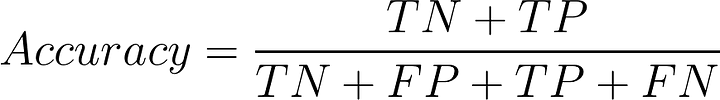)

In [30]:
rf_acc = accuracy_score(y_test, rf_pred)
print("Random Forest Accuracy: {:.2f}%".format(rf_acc*100))

Random Forest Accuracy: 81.79%


![1_VXnUvOEdf3IiYVCD6Wd2vg[1].png](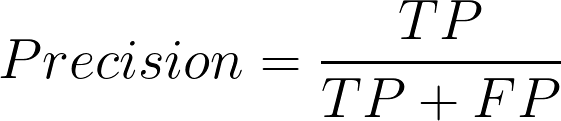)

![1_Aj3aYW4vwYAoJqyL36PVtQ[1].png](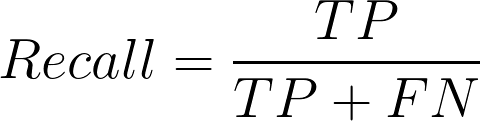)

![1_9uo7HN1pdMlMwTbNSdyO3A[1].png](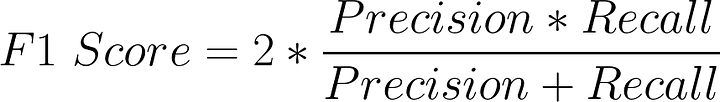)

In [31]:
target_names = ['label: {0}'.format(i) for i in cleanData['label'].unique()]

#print(metrics.classification_report(y_test, rf.predict(X_test), target_names=target_names))
print(metrics.classification_report(y_test, rf_pred, target_names=target_names))

              precision    recall  f1-score   support

    label: 0       0.82      1.00      0.90     65422
    label: 1       0.53      0.01      0.02     14589

    accuracy                           0.82     80011
   macro avg       0.68      0.50      0.46     80011
weighted avg       0.77      0.82      0.74     80011



In [58]:
# count the number of 0s and 1s in y_test
value_counts = y_test.value_counts()

print("Number of 0s in y_test:", value_counts[0])
print("Number of 1s in y_test:", value_counts[1])

Number of 0s in y_test: 65422
Number of 1s in y_test: 14589


In [59]:
# count the number of 0s and 1s in y_test
value_counts = rf_pred.value_counts()

print("Number of 0s in rf_pred:", value_counts[0])
print("Number of 1s in rf_pred:", value_counts[1])

AttributeError: ignored

In [32]:
#attributes = cleanData.drop(columns=['Close +1w change %','label','altLabel']).columns.tolist()
#i = 0
#for attribute in attributes:
#  print(i, attribute)
#  i=i+1

In [33]:
#feature importance
#featI = pd.Series(rf.feature_importances_).sort_values(ascending=False)
#print(featI)

### xgboost optimization

In [22]:
#get a smaller subset of data for multiple iterations of modeling

X_noUse, X_short, y_noUse, y_short = train_test_split(X_resampled_pca, y_resampled, test_size=0.1, random_state=11)
X_short.shape

(16645, 8)

In [28]:
#import pandas as pd
from sklearn.model_selection import GridSearchCV
#from sklearn.metrics import accuracy_score, precision_score, f1_score
from xgboost import XGBClassifier

# Define the hyperparameters to iterate over
param_grid = {
    #'max_depth': [2, 4, 6, 10],
    #'learning_rate': [0.01, 0.1, 0.5],
    #'n_estimators': [100, 200, 300],
    #'subsample': [0.1, 0.6, 1.0],
    #'colsample_bytree': [0.5, 0.8, 1.0],
    #'gamma': [0, 0.1, 0.5, 2, 5],
    #'booster': ['gbtree', 'gblinear', 'dart'],
    'min_child_weight': [0, 0.5, 1, 2, 5],
    'tree_method': ['hist', 'approx'],
    'grow_policy': ['lossguide', 'depthwise'],
    'max_bin': [128, 256, 512, 1024]
}

# Define the XGBoost classifier and GridSearchCV object
xgb = XGBClassifier()
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the data
grid_search.fit(X_short, y_short)

# Create a DataFrame to store the results
results_df = pd.DataFrame(grid_search.cv_results_)

# Add a column to the DataFrame that concatenates the values of the hyperparameters
results_df['params_str'] = results_df.params.apply(str)

# Calculate accuracy, precision, and F1 score for the "1" label
y_pred = grid_search.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

# Add the metrics to the DataFrame
results_df['accuracy'] = accuracy
results_df['precision'] = precision
results_df['f1'] = f1

# Sort the DataFrame by the mean test score in descending order
results_df = results_df.sort_values('mean_test_score', ascending=False)

# Save the DataFrame to an Excel file
results_df.to_excel(dataURL + 'xgboost_results3.xlsx', index=False)

results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_grow_policy,param_max_bin,param_min_child_weight,param_tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,params_str,accuracy,precision,f1
19,1.804523,0.455025,0.017701,0.000777,lossguide,256,5,approx,"{'grow_policy': 'lossguide', 'max_bin': 256, '...",0.566837,0.580655,0.577951,0.573145,0.565635,0.572845,0.005920,1,"{'grow_policy': 'lossguide', 'max_bin': 256, '...",0.592881,0.232883,0.324947
59,1.358173,0.003974,0.017415,0.000978,depthwise,256,5,approx,"{'grow_policy': 'depthwise', 'max_bin': 256, '...",0.566837,0.580655,0.577951,0.573145,0.565635,0.572845,0.005920,1,"{'grow_policy': 'depthwise', 'max_bin': 256, '...",0.592881,0.232883,0.324947
66,0.491794,0.028312,0.017006,0.001263,depthwise,512,2,hist,"{'grow_policy': 'depthwise', 'max_bin': 512, '...",0.571042,0.568940,0.568639,0.586663,0.566837,0.572424,0.007243,3,"{'grow_policy': 'depthwise', 'max_bin': 512, '...",0.592881,0.232883,0.324947
26,0.507147,0.028527,0.016943,0.000340,lossguide,512,2,hist,"{'grow_policy': 'lossguide', 'max_bin': 512, '...",0.571042,0.568940,0.568639,0.586663,0.566837,0.572424,0.007243,3,"{'grow_policy': 'lossguide', 'max_bin': 512, '...",0.592881,0.232883,0.324947
24,0.928674,0.077669,0.027904,0.008508,lossguide,512,1,hist,"{'grow_policy': 'lossguide', 'max_bin': 512, '...",0.570141,0.584860,0.576750,0.571643,0.551817,0.571042,0.010902,5,"{'grow_policy': 'lossguide', 'max_bin': 512, '...",0.592881,0.232883,0.324947
64,0.690155,0.175845,0.024736,0.009711,depthwise,512,1,hist,"{'grow_policy': 'depthwise', 'max_bin': 512, '...",0.570141,0.584860,0.576750,0.571643,0.551817,0.571042,0.010902,5,"{'grow_policy': 'depthwise', 'max_bin': 512, '...",0.592881,0.232883,0.324947
18,0.490792,0.106206,0.026655,0.009717,lossguide,256,5,hist,"{'grow_policy': 'lossguide', 'max_bin': 256, '...",0.556323,0.585461,0.566837,0.578853,0.563533,0.570201,0.010546,7,"{'grow_policy': 'lossguide', 'max_bin': 256, '...",0.592881,0.232883,0.324947
58,0.293707,0.008095,0.020418,0.005612,depthwise,256,5,hist,"{'grow_policy': 'depthwise', 'max_bin': 256, '...",0.556323,0.585461,0.566837,0.578853,0.563533,0.570201,0.010546,7,"{'grow_policy': 'depthwise', 'max_bin': 256, '...",0.592881,0.232883,0.324947
23,2.129612,0.452763,0.020390,0.007357,lossguide,512,0.5,approx,"{'grow_policy': 'lossguide', 'max_bin': 512, '...",0.565035,0.579153,0.577351,0.573145,0.553620,0.569661,0.009382,9,"{'grow_policy': 'lossguide', 'max_bin': 512, '...",0.592881,0.232883,0.324947
63,1.878284,0.107609,0.023262,0.008174,depthwise,512,0.5,approx,"{'grow_policy': 'depthwise', 'max_bin': 512, '...",0.565035,0.579153,0.577351,0.573145,0.553620,0.569661,0.009382,9,"{'grow_policy': 'depthwise', 'max_bin': 512, '...",0.592881,0.232883,0.324947


### xg boost

In [34]:
# calculate the ratio of negative to positive samples in the training data
#neg_to_pos_ratio = sum(y_train == 0) / sum(y_train == 1)
neg_to_pos_ratio = sum(y_resampled == 0) / sum(y_resampled == 1)
neg_to_pos_ratio

1.0

In [35]:
# Define a custom evaluation metric function that computes precision
def precision(y_pred, y_true):
    y_pred = np.round(y_pred)
    return 'precision', precision_score(y_true, y_pred)

https://xgboost.readthedocs.io/en/stable/parameter.html

In [36]:
'''
xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              #scale_pos_weight=class_weight, 
                              booster = 'gbtree',
                              learning_rate = 0.15,
                              min_split_loss = 2,
                              max_depth = 9,
                              min_child_weight = 2,
                              subsample = 0.5,
                              tree_method = 'hist',
                              grow_policy = 'lossguide',
                              max_bin = 512,
                              #scale_pos_weight=neg_to_pos_ratio * 3,
                              #eval_metric='rmse', # precision, #'f1',
                              random_state = 11)
'''

'\nxgb_model = xgb.XGBClassifier(objective="binary:logistic", \n                              #scale_pos_weight=class_weight, \n                              booster = \'gbtree\',\n                              learning_rate = 0.15,\n                              min_split_loss = 2,\n                              max_depth = 9,\n                              min_child_weight = 2,\n                              subsample = 0.5,\n                              tree_method = \'hist\',\n                              grow_policy = \'lossguide\',\n                              max_bin = 512,\n                              #scale_pos_weight=neg_to_pos_ratio * 3,\n                              #eval_metric=\'rmse\', # precision, #\'f1\',\n                              random_state = 11)\n'

In [37]:
# train an XGBoost model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", 
                              learning_rate = 0.1, 
                              max_depth = 8, 
                              n_estimators = 300,
                              booster = 'gbtree', 
                              colsample_bytree = 0.2, 
                              gamma = 5,
                              grow_policy = 'lossguide', 
                              max_bin = 256, 
                              min_child_weight = 5, 
                              tree_method = 'approx',
                              scale_pos_weight=neg_to_pos_ratio * 2.5,
                              eval_metric = precision,
                              random_state = 11)
xgb_model.fit(X_resampled_pca, y_resampled)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.2, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=<function precision at 0x7f3450534ca0>,
              feature_types=None, gamma=5, gpu_id=None, grow_policy='lossguide',
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=256, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=11, ...)

In [38]:
# Save the trained model to a file using joblib
joblib.dump(xgb_model, dataURL + 'models/XGBmodel_weekly.joblib')

['/content/drive/MyDrive/Colab Notebooks/NASDAQ_data/models/XGBmodel_weekly.joblib']

In [39]:
# evaluate the XGBoost model
xgb_proba = xgb_model.predict_proba(X_test_pca)

In [40]:
xgb_pred = [1 if proba[1] >= 0.78 else 0 for proba in xgb_proba]
xgb_acc = accuracy_score(y_test, xgb_pred)
print("XGBoost Accuracy: {:.2f}%".format(xgb_acc*100))

XGBoost Accuracy: 75.91%


In [41]:
# evaluate the XGBoost model
#xgb_pred = xgb_model.predict(X_test)
#xgb_acc = accuracy_score(y_test, xgb_pred)
#print("XGBoost Accuracy: {:.2f}%".format(xgb_acc*100))

In [42]:
target_names = ['label: {0}'.format(i) for i in cleanData['label'].unique()]

print(metrics.classification_report(y_test, xgb_pred, target_names=target_names))

              precision    recall  f1-score   support

    label: 0       0.84      0.87      0.86     65422
    label: 1       0.31      0.27      0.29     14589

    accuracy                           0.76     80011
   macro avg       0.58      0.57      0.57     80011
weighted avg       0.75      0.76      0.75     80011



In [43]:
# count the number of 0s and 1s in y_test
value_counts = y_test.value_counts()

print("Number of 0s in y_test:", value_counts[0])
print("Number of 1s in y_test:", value_counts[1])

Number of 0s in y_test: 65422
Number of 1s in y_test: 14589


In [44]:
# count the number of 0s and 1s in xgb_pred
value_counts_xgb = pd.Series(xgb_pred).value_counts()

print("Number of 0s in xgb_pred:", value_counts_xgb[0])
print("Number of 1s in xgb_pred:", value_counts_xgb[1])

Number of 0s in xgb_pred: 67514
Number of 1s in xgb_pred: 12497


In [45]:


# predict probabilities
probs = xgb_model.predict_proba(X_test_pca)[:, 1]

# calculate precision for different thresholds
thresholds = np.arange(0, 1.01, 0.01)
precision_scores = []
for threshold in thresholds:
    y_pred = (probs > threshold).astype(int)
    precision = precision_score(y_test, y_pred)
    precision_scores.append(precision)

# find optimal threshold
optimal_threshold = thresholds[np.argmax(precision_scores)]
print("Optimal threshold:", optimal_threshold)

# evaluate model with optimal threshold
y_pred = (probs > optimal_threshold).astype(int)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)


Optimal threshold: 0.96
Precision: 0.631578947368421
Recall: 0.0008225375282747275
F1 score: 0.0016429353778751367


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined a

### tensorflow - keras

In [46]:
X_resampled_pca.shape

(166442, 12)

In [47]:
# Define the number of numerical attributes
num_attributes = X_resampled_pca.shape[1]

# Define the model architecture
TFmodel = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(num_attributes,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='tanh'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(11, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [48]:
# Compile the model
TFmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [49]:
# Train the model on your data
TFmodel.fit(X_resampled_pca, y_resampled, epochs=150, batch_size=10000)


Epoch 1/150
17/17 [==============================] - 2s 33ms/step - loss: 0.6883 - accuracy: 0.5450
Epoch 2/150
17/17 [==============================] - 1s 35ms/step - loss: 0.6785 - accuracy: 0.5709
Epoch 3/150
17/17 [==============================] - 1s 31ms/step - loss: 0.6702 - accuracy: 0.5847
Epoch 4/150
17/17 [==============================] - 1s 32ms/step - loss: 0.6666 - accuracy: 0.5934
Epoch 5/150
17/17 [==============================] - 1s 31ms/step - loss: 0.6651 - accuracy: 0.5956
Epoch 6/150
17/17 [==============================] - 1s 32ms/step - loss: 0.6644 - accuracy: 0.5974
Epoch 7/150
17/17 [==============================] - 1s 31ms/step - loss: 0.6639 - accuracy: 0.5973
Epoch 8/150
17/17 [==============================] - 1s 33ms/step - loss: 0.6632 - accuracy: 0.5988
Epoch 9/150
17/17 [==============================] - 1s 33ms/step - loss: 0.6627 - accuracy: 0.5999
Epoch 10/150
17/17 [==============================] - 1s 32ms/step - loss: 0.6623 - accuracy: 0.6008

In [50]:
# Save the trained model to a file using joblib
joblib.dump(TFmodel, dataURL + 'models/TFmodel_weekly.joblib')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......dense_1
.........vars
............0
............1
......dense_2
.........vars
............0
............1
......dense_3
.........vars
............0
............1
......dense_4
.........vars
............0
............1
......dense_5
.........vars
............0
............1
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........13
.........14
.........15
.........16
.........17
.........18
.........19
.........2
.........20
.........21
.........22
.........23
.........24
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                 

['/content/drive/MyDrive/Colab Notebooks/NASDAQ_data/models/TFmodel_weekly.joblib']

In [51]:
# Make predictions on your test data
y_pred_proba = TFmodel.predict(X_test_pca)



2501/2501 [==============================] - 5s 2ms/step


In [52]:
# Convert predicted probabilities to binary labels using a threshold of 0.8
y_pred = (y_pred_proba > 0.78).astype(int)

In [53]:
from sklearn.metrics import precision_recall_fscore_support

# Evaluate the model performance using accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print('Accuracy:', accuracy)
#print('Precision:', precision)
#print('Recall:', recall)
#print('F1-score:', f1_score)

Accuracy: 0.8103385784454638


In [54]:
target_names = ['label: {0}'.format(i) for i in cleanData['label'].unique()]

print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    label: 0       0.82      0.98      0.89     65422
    label: 1       0.39      0.07      0.12     14589

    accuracy                           0.81     80011
   macro avg       0.61      0.52      0.50     80011
weighted avg       0.74      0.81      0.75     80011



In [55]:
y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

### tensorflow mixed model

#### temp

In [ ]:
# Extract inputs as a numpy array
'''
inputs_candles = cleanData[['Normalized candlestick open -0w',
					 'Normalized candlestick high -0w',
					 'Normalized candlestick low -0w',
					 'Normalized candlestick close -0w',
					 'Normalized candlestick open -1w',
					 'Normalized candlestick high -1w',
					 'Normalized candlestick low -1w',
					 'Normalized candlestick close -1w',
					 'Normalized candlestick open -2w',
					 'Normalized candlestick high -2w',
					 'Normalized candlestick low -2w',
					 'Normalized candlestick close -2w',
					 'Normalized candlestick open -3w',
					 'Normalized candlestick high -3w',
					 'Normalized candlestick low -3w',
					 'Normalized candlestick close -3w',
					 'Normalized candlestick open -4w',
					 'Normalized candlestick high -4w',
					 'Normalized candlestick low -4w',
					 'Normalized candlestick close -4w',
					 'Normalized candlestick open -5w',
					 'Normalized candlestick high -5w',
					 'Normalized candlestick low -5w',
					 'Normalized candlestick close -5w',
					 'Normalized candlestick open -6w',
					 'Normalized candlestick high -6w',
					 'Normalized candlestick low -6w',
					 'Normalized candlestick close -6w',
					 'Normalized candlestick open -7w',
					 'Normalized candlestick high -7w',
					 'Normalized candlestick low -7w',
					 'Normalized candlestick close -7w',
					 'Normalized candlestick open -8w',
					 'Normalized candlestick high -8w',
					 'Normalized candlestick low -8w',
					 'Normalized candlestick close -8w',
					 'Normalized candlestick open -9w',
					 'Normalized candlestick high -9w',
					 'Normalized candlestick low -9w',
					 'Normalized candlestick close -9w']].to_numpy()

inputs_volumes = cleanData[['Ticker Normalized Volume', 
					'sp500 normalized volume']].to_numpy()

inputs_stock_ratios = cleanData[['Ticker Price / SMA2',
						 'Ticker Price / SMA10',
						 'Ticker Price / SMA20',
						 'Ticker Price / SMA50',
						 'Ticker Price / SMA200']].to_numpy()

inputs_index_ratios = cleanData[['SP500 Price : SMA2',
						 'SP500 Price : SMA10',
						 'SP500 Price : SMA20',
						 'SP500 Price : SMA50',
						 'SP500 Price : SMA200']].to_numpy()
'''
#X_train = X.iloc[:trainData]
#X_test  = X.iloc[trainData:]
#y_train = y.iloc[:trainData]
#y_test  = y.iloc[trainData:]

#outputs = cleanData['label'].to_numpy()

# Concatenate inputs
#inputs = np.concatenate([inputs_candles, inputs_stock_ratios, inputs_index_ratios, inputs_volumes], axis=1)

# Convert outputs to one-hot encoding
#num_classes = 2
#outputs = tf.keras.utils.to_categorical(outputs, num_classes)

# Split data into training and testing sets
#train_ratio = 0.95
#num_train_samples = int(train_ratio * inputs.shape[0])
#train_inputs = inputs[:num_train_samples]   #X_train
#train_outputs = outputs[:num_train_samples] #y_train
#test_inputs = inputs[num_train_samples:]    #X_test
#test_outputs = outputs[num_train_samples:]  #y_test

"\ninputs_candles = cleanData[['Normalized candlestick open -0w',\n\t\t\t\t\t 'Normalized candlestick high -0w',\n\t\t\t\t\t 'Normalized candlestick low -0w',\n\t\t\t\t\t 'Normalized candlestick close -0w',\n\t\t\t\t\t 'Normalized candlestick open -1w',\n\t\t\t\t\t 'Normalized candlestick high -1w',\n\t\t\t\t\t 'Normalized candlestick low -1w',\n\t\t\t\t\t 'Normalized candlestick close -1w',\n\t\t\t\t\t 'Normalized candlestick open -2w',\n\t\t\t\t\t 'Normalized candlestick high -2w',\n\t\t\t\t\t 'Normalized candlestick low -2w',\n\t\t\t\t\t 'Normalized candlestick close -2w',\n\t\t\t\t\t 'Normalized candlestick open -3w',\n\t\t\t\t\t 'Normalized candlestick high -3w',\n\t\t\t\t\t 'Normalized candlestick low -3w',\n\t\t\t\t\t 'Normalized candlestick close -3w',\n\t\t\t\t\t 'Normalized candlestick open -4w',\n\t\t\t\t\t 'Normalized candlestick high -4w',\n\t\t\t\t\t 'Normalized candlestick low -4w',\n\t\t\t\t\t 'Normalized candlestick close -4w',\n\t\t\t\t\t 'Normalized candlestick open 

#### model

In [ ]:
X_train_np = X_train.to_numpy()  #train_inputs
X_test_np  = X_test.to_numpy()   #test_inputs
y_train_np = y_train.to_numpy()  #train_outputs
y_test_np  = y_test.to_numpy()   #test_outputs


In [ ]:
# Convert outputs to one-hot encoding
num_classes = 2
y_test_np = tf.keras.utils.to_categorical(y_test_np, num_classes)
y_train_np = tf.keras.utils.to_categorical(y_train_np, num_classes)

# Define model architecture
mixedModel = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_np.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile model
mixedModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train model
history = mixedModel.fit(X_train_np, y_train_np, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
14060/14060 [==============================] - 48s 3ms/step - loss: 0.4093 - accuracy: 0.8500 - val_loss: 0.3904 - val_accuracy: 0.8611
Epoch 2/10
14060/14060 [==============================] - 51s 4ms/step - loss: 0.4056 - accuracy: 0.8502 - val_loss: 0.3922 - val_accuracy: 0.8612
Epoch 3/10
14060/14060 [==============================] - 46s 3ms/step - loss: 0.4036 - accuracy: 0.8503 - val_loss: 0.3923 - val_accuracy: 0.8612
Epoch 4/10
14060/14060 [==============================] - 46s 3ms/step - loss: 0.4018 - accuracy: 0.8506 - val_loss: 0.3926 - val_accuracy: 0.8611
Epoch 5/10
14060/14060 [==============================] - 53s 4ms/step - loss: 0.4003 - accuracy: 0.8509 - val_loss: 0.3907 - val_accuracy: 0.8611
Epoch 6/10
14060/14060 [==============================] - 51s 4ms/step - loss: 0.3989 - accuracy: 0.8513 - val_loss: 0.3882 - val_accuracy: 0.8611
Epoch 7/10
14060/14060 [==============================] - 46s 3ms/step - loss: 0.3978 - accuracy: 0.8515 - val_loss: 0

In [ ]:
# Evaluate model on test set
#test_loss, test_acc = mixedModel.evaluate(X_test_np, y_test_np)
#print('Test accuracy:', test_acc)

In [ ]:
# Get model predictions on test set
#test_predictions = mixedModel.predict(test_inputs)

# Apply threshold to predictions
#test_predictions = (test_predictions[:,1] > 0.8).astype(int)

# Compute accuracy on test set with thresholded predictions
#test_accuracy = np.mean(test_predictions == np.argmax(test_outputs, axis=1))

#print('Test accuracy with thresholded predictions:', test_accuracy)

In [ ]:
mM_pred_proba = mixedModel.predict(X_test_np)

mM_pred = [1 if proba[1] >= 0.8 else 0 for proba in mM_pred_proba]

359/359 [==============================] - 1s 2ms/step


In [ ]:
target_names = ['label: {0}'.format(i) for i in cleanData['label'].unique()]

print(metrics.classification_report(y_test, mM_pred, target_names=target_names))

              precision    recall  f1-score   support

    label: 1       0.87      1.00      0.93     10014
    label: 0       0.00      0.00      0.00      1464

    accuracy                           0.87     11478
   macro avg       0.44      0.50      0.47     11478
weighted avg       0.76      0.87      0.81     11478



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM

In [56]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Create an SVM classifier
clf = svm.SVC(kernel='linear')

# Fit the classifier to the training data
clf.fit(X_resampled_pca, y_resampled)

# Make predictions on the testing data
clf_pred = clf.predict(X_test_pca)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, clf_pred)
print("Accuracy: ", accuracy)


Accuracy:  0.5783454774968442


In [57]:
target_names = ['label: {0}'.format(i) for i in cleanData['label'].unique()]

print(metrics.classification_report(y_test, clf_pred, target_names=target_names))

              precision    recall  f1-score   support

    label: 0       0.85      0.59      0.70     65422
    label: 1       0.22      0.53      0.31     14589

    accuracy                           0.58     80011
   macro avg       0.54      0.56      0.50     80011
weighted avg       0.73      0.58      0.63     80011



### LSTM @ TensorFlow

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming that your data is stored in X and your labels are stored in y
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for input into an LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model architecture
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=50, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model to the training data
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Make predictions on the testing data
y_pred = model.predict_classes(X_test)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)


### LSTM @ PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming that your data is stored in X and your labels are stored in y
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data for input into an LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model architecture
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        output = self.sigmoid(output)
        return output

input_size = 1
hidden_size = 50
output_size = 1

model = LSTMModel(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Convert the data to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred.squeeze(), y_train)
    loss.backward()
    optimizer.step()

# Make predictions on the testing data
y_pred = model(X_test)
y_pred_class = (y_pred > 0.5).float()

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test.numpy(), y_pred_class.detach().numpy())
print("Accuracy: ", accuracy)


# fundamental analysis

## FA parameters description 

### EN

[EN]

A full fundamental analysis of a stock typically includes the examination of a number of financial metrics and ratios to determine the overall financial health and potential for future growth of a company. Some of the key parameters that are typically analyzed in a fundamental analysis include:

 1. Revenue: The amount of money a company generates from its operations. A higher revenue is generally considered a positive indicator of the company's financial health.

 2. Earnings per share (EPS): This measures a company's profitability by dividing its net income by the number of outstanding shares. An EPS of greater than 1 is generally considered a good sign, while an EPS of less than 1 may indicate that the company is not making a profit. A higher EPS generally indicates a better financial performance.

 3. Price to earnings ratio (P/E): This measures the price of a stock relative to its earnings. A P/E ratio of less than 15 is generally considered low and may indicate that the stock is undervalued, while a P/E ratio of greater than 25 may indicate that the stock is overvalued.

 4. Debt to Equity Ratio (D/E Ratio): A financial leverage ratio that measures the proportion of a company's debt compared to its equity. A high D/E ratio may indicate that a company is taking on too much debt and may be in a risky financial position. A normal range for D/E ratio is between 0.5 and 2.

 5. Return on equity (ROE): This measures a company's efficiency at generating profits from its equity. An ROE of greater than 10% is generally considered good, while an ROE of less than 5% may indicate that the company is not generating sufficient profits from its equity. A normal ROE is between 10% and 15%. A high ROE indicates that a company is generating a good return on investment for its shareholders.

 6. Gross profit margin: This measures the amount of money a company makes after deducting the cost of goods sold. A gross profit margin of greater than 40% is generally considered good, while a margin of less than 20% may indicate that the company is not generating sufficient profit from its operations. A high gross profit margin indicates that the company is efficient at managing its costs and generating revenue. A gross profit margin in the range of 30-40% is considered normal, but can vary depending on the industry

 7. Operating Profit Margin: A profitability ratio that calculates the percentage of sales that exceeds the company's operating expenses. A higher operating profit margin indicates a higher level of efficiency and profitability.

 8. Dividend yield: This measures the amount of money a company returns to its shareholders in the form of dividends. A dividend yield of greater than 2% is generally considered good, while a yield of less than 1% may indicate that the company is not returning much money to its shareholders. A high dividend yield can indicate a steady income stream, but can also be a sign that the company is not reinvesting its profits for future growth. A dividend yield in the range of 2-5% is considered normal, but can vary depending on the industry and the company's dividend policy.

 9. Price to Book Value (P/B Ratio): A valuation ratio that compares a company's current stock price to its book value (the value of its assets minus its liabilities). A P/B ratio of less than 1 may indicate that a stock is undervalued, while a P/B ratio of more than 1 may indicate that a stock is overvalued.

 10. EBITDA and EBITDA margin are useful for comparing the operating performance of different companies in the same industry and for analyzing the trend of a company's operating performance over time. However, it's important to note that EBITDA is not a recognized financial metric under Generally Accepted Accounting Principles (GAAP) and can sometimes be used to conceal or misrepresent a company's financial performance.
 
  10 A. EBITDA stands for Earnings Before Interest, Taxes, Depreciation, and Amortization. It is a financial metric that measures a company's operating performance and is often used as an alternative to net income. The purpose of EBITDA is to show a company's earnings before accounting for financing and tax expenses, as well as depreciation and amortization charges, which can be significant and vary greatly between companies.
  
  10 B. EBITDA margin, on the other hand, is the ratio of a company's EBITDA to its total revenue. It measures a company's ability to generate profits from its sales and is expressed as a percentage. A higher EBITDA margin indicates that a company is generating more profits from its sales and has a higher operating efficiency, while a lower margin suggests the opposite.

 11. Beta is a measure of a stock's volatility in relation to the overall market used in stock analysis. It quantifies the risk of an individual stock or a portfolio of stocks, with a beta of 1 indicating the stock will move with the market, a beta greater than 1 indicating higher volatility than the market, and a beta less than 1 indicating lower volatility. Beta can be a useful tool for investors to assess potential risks and rewards, but it is important to keep in mind that it only measures systematic risk and can change over time.

### PL

[PL]

Pełna analiza fundamentalna akcji zwykle obejmuje badanie szeregu wskaźników i wskaźników finansowych w celu określenia ogólnej kondycji finansowej i potencjału przyszłego wzrostu firmy. Niektóre z kluczowych parametrów, które są zazwyczaj analizowane w analizie fundamentalnej, obejmują:

  1. Przychód: Kwota pieniędzy, którą firma generuje ze swojej działalności. Wyższy przychód jest ogólnie uważany za pozytywny wskaźnik kondycji finansowej firmy.

  2. Zysk na akcję (EPS): Mierzy rentowność firmy poprzez podzielenie jej dochodu netto przez liczbę akcji pozostających w obrocie. EPS większy niż 1 jest ogólnie uważany za dobry znak, podczas gdy EPS mniejszy niż 1 może wskazywać, że firma nie osiąga zysków. Wyższy EPS generalnie wskazuje na lepsze wyniki finansowe.

  3. Wskaźnik ceny do zysku (P/E): Mierzy cenę akcji w stosunku do jej zysków. Wskaźnik P/E mniejszy niż 15 jest ogólnie uważany za niski i może wskazywać, że akcje są niedowartościowane, podczas gdy wskaźnik P/E większy niż 25 może wskazywać, że akcje są przewartościowane.

  4. Wskaźnik zadłużenia do kapitału własnego (D/E Ratio): Wskaźnik dźwigni finansowej, który mierzy stosunek zadłużenia spółki do jej kapitału własnego. Wysoki wskaźnik D/E może wskazywać, że firma zaciąga zbyt duże długi i może znajdować się w ryzykownej sytuacji finansowej. Normalny zakres stosunku D/E wynosi od 0,5 do 2.

  5. Zwrot z kapitału własnego (ROE): Mierzy efektywność firmy w generowaniu zysków z kapitału własnego. ROE większe niż 10% jest ogólnie uważane za dobre, podczas gdy ROE mniejsze niż 5% może wskazywać, że firma nie generuje wystarczających zysków z kapitału własnego. Normalny ROE wynosi od 10% do 15%. Wysoki ROE wskazuje, że firma generuje dobry zwrot z inwestycji dla swoich akcjonariuszy.

  6. Marża zysku brutto: Mierzy ilość pieniędzy, jaką firma zarabia po odjęciu kosztu sprzedanych towarów. Marża zysku brutto powyżej 40% jest ogólnie uważana za dobrą, natomiast marża poniżej 20% może wskazywać, że firma nie generuje wystarczających zysków ze swojej działalności. Wysoka marża zysku brutto świadczy o tym, że firma skutecznie zarządza swoimi kosztami i generuje przychody. Marża zysku brutto w przedziale 30-40% jest uważana za normalną, ale może się różnić w zależności od branży

  7. Marża zysku operacyjnego: Wskaźnik rentowności, który oblicza procent sprzedaży przekraczający koszty operacyjne firmy. Wyższa marża zysku operacyjnego wskazuje na wyższy poziom efektywności i rentowności.

  8. Stopa dywidendy: Mierzy ilość pieniędzy, które firma zwraca swoim akcjonariuszom w formie dywidend. Stopa dywidendy większa niż 2% jest ogólnie uważana za dobrą, podczas gdy stopa zwrotu poniżej 1% może wskazywać, że spółka nie zwraca dużo pieniędzy swoim akcjonariuszom. Wysoka stopa dywidendy może wskazywać na stały strumień dochodów, ale może też oznaczać, że firma nie reinwestuje swoich zysków w przyszły wzrost. Stopa dywidendy w przedziale 2-5% jest uważana za normalną, ale może się różnić w zależności od branży i polityki dywidendowej spółki.

  9. Cena do wartości księgowej (współczynnik P/B): Wskaźnik wyceny, który porównuje aktualną cenę akcji spółki z jej wartością księgową (wartość jej aktywów minus zobowiązania). Wskaźnik P/B mniejszy niż 1 może wskazywać, że akcje są niedowartościowane, podczas gdy wskaźnik P/B większy niż 1 może wskazywać, że akcje są przewartościowane.

  10. EBITDA i marża EBITDA są przydatne do porównywania wyników operacyjnych różnych firm z tej samej branży oraz do analizy trendów wyników operacyjnych firmy w czasie. Należy jednak pamiętać, że EBITDA nie jest uznawaną metryką finansową zgodnie z ogólnie przyjętymi zasadami rachunkowości (GAAP) i czasami może być wykorzystywana do ukrywania lub fałszywego przedstawiania wyników finansowych firmy.
 
   10 A. EBITDA oznacza zysk przed odsetkami, podatkami, amortyzacją i amortyzacją. Jest to miernik finansowy, który mierzy wyniki operacyjne firmy i jest często używany jako alternatywa dla dochodu netto. Celem EBITDA jest pokazanie zysków firmy przed uwzględnieniem wydatków finansowych i podatkowych, a także amortyzacji, które mogą być znaczne i różnią się znacznie w zależności od firmy.
  
   10 B. Marża EBITDA to natomiast stosunek EBITDA firmy do jej całkowitych przychodów. Mierzy zdolność przedsiębiorstwa do generowania zysków ze sprzedaży i wyrażany jest w procentach. Wyższa marża EBITDA wskazuje, że firma generuje większe zyski ze sprzedaży i ma wyższą efektywność operacyjną, podczas gdy niższa marża sugeruje coś przeciwnego.
  
  11. Beta jest miarą zmienności akcji w stosunku do całego rynku stosowaną w analizie akcji. Określa ilościowo ryzyko pojedynczej akcji lub portfela akcji, przy czym beta 1 wskazuje, że akcje będą się zmieniać wraz z rynkiem, beta większa niż 1 wskazuje na wyższą zmienność niż rynek, a beta mniejsza niż 1 wskazuje na niższą zmienność. Beta może być przydatnym narzędziem dla inwestorów do oceny potencjalnego ryzyka i korzyści, ale należy pamiętać, że mierzy ona tylko ryzyko systematyczne i może zmieniać się w czasie.

## DB forming function

In [ ]:
def readTickerData(ticker):
  api_key = 'S8CPGB36QUA6E907'
  function = "OVERVIEW"
  url = f"https://www.alphavantage.co/query?function={function}&symbol={ticker}&apikey={api_key}"

  ExecuteDataRead = True
  Repeats = 0

  while ExecuteDataRead:
    try:
      # YahooFinance data
      YF_StockData_fast = yf.Ticker(ticker).fast_info
      YF_StockData      = yf.Ticker(ticker).info

      # AlphaVantage data
      response = requests.get(url)
      AV_StockData = response.json()
      #ticker = ticker

      # ustalenie branzy
      sector = AV_StockData["Sector"]
      industry = AV_StockData["Industry"]

      # RPS - Revenue Per Share
      rps = float(YF_StockData["revenuePerShare"])

      # PEG Ratio - Price/Earnings-to-Growth
      peg_ratio = float(YF_StockData["pegRatio"])

      # forward P/E
      pe_forward = float(YF_StockData['forwardPE'])

      # D/E Ratio - Debt to Equity
      de_ratio = float(YF_StockData['debtToEquity'])

      # ROE - Return On Equity
      roe = float(YF_StockData["returnOnEquity"])

      # Gross Margin
      gross_margin = float(YF_StockData['grossMargins'])

      # P/B Ratio - Price to Book Value
      pb_ratio = float(YF_StockData["priceToBook"])

      # EBITDA Margin
      ebitda_margin = float(YF_StockData['ebitdaMargins'])

      # Beta
      beta = float(YF_StockData["beta"])

      # current price / 50 day average
      priceTo50DayAvg = float(YF_StockData_fast['lastPrice']) / float(YF_StockData_fast['fiftyDayAverage'])

      # current price / 200 day average
      priceTo200DayAvg = float(YF_StockData_fast['lastPrice']) / float(YF_StockData_fast['twoHundredDayAverage'])

      # current volume
      volume = float(YF_StockData_fast['lastVolume'])

      # end data read
      ExecuteDataRead = False
    except:
      Repeats = Repeats + 1
      if Repeats < 4:
        # an error ocurred, wait 10s and read again
        print ("        error, repeat ", Repeats)
        time.sleep(5)
        ExecuteDataRead = True
      else:
        stockParams = ["Ticker", "Sector", "Industry", "RPS", "PEG", "Forward P/E", "D/E", "ROE", "Gross Margin", "P/B Ratio", "EBITDA Margin", "Beta", "Price / 50D Avg", "Price / 200D Avg", "Volume"]
        # tickerData - empty
        tickerData = pd.DataFrame(columns = stockParams)
        print ("        error, dropping ticker. ")
        return tickerData
  # ****************************************************************
  # Create a Pandas DataFrame with the data
  tickerData = pd.DataFrame({
      "Ticker": [ticker],
      "Sector": [sector],
      "Industry": [industry],
      "RPS": [rps],
      "PEG": [peg_ratio],
      "Forward P/E": [pe_forward],
      "D/E": [de_ratio],
      "ROE": [roe],
      "Gross Margin": [gross_margin],
      "P/B Ratio": [pb_ratio],
      "EBITDA Margin": [ebitda_margin],
      "Beta": [beta],
      "Price / 50D Avg": [priceTo50DayAvg],
      "Price / 200D Avg": [priceTo200DayAvg],
      "Volume": [volume]
    })
  time.sleep(1)

  return tickerData

In [ ]:
def formDB(dataURL):
    # Get a list of all NASDAQ stocks
    tickerList = pd.read_csv(dataURL + 'sp500_screener.csv')['Symbol']
    tickerList.dropna(inplace=True)
    #tickerList = ['A','NVDA', 'MSFT', 'ABBV', 'GOOGL', 'AAPL', 'ABT', 'DIS', 'PFE', 'SONY']

    stockParams = ["Ticker", ''' "Sector", "Industry", ''' "RPS", "PEG", "Forward P/E", "D/E", "ROE", "Gross Margin", "P/B Ratio", "EBITDA Margin", "Beta", "Price / 50D Avg", "Price / 200D Avg", "Volume"]

    # create an Empty DataFrame object With column names only
    database = pd.DataFrame(columns = stockParams)

    for ticker in tickerList:
      # Retrieve stock data from Yahoo Finance & Alpha vantage
      print(ticker + " ...")
      tickerData = readTickerData(ticker)
      database = pd.concat([database, tickerData], ignore_index=True)
      print("    ... done")

    # Save the DataFrame to an Excel file
    database.to_excel(dataURL + "NASDAQ_database.xlsx", index=False)
    print("== Plik zapisany! ==")
    return database

In [ ]:
Data = formDB(dataURL)

AAPL ...
    ... done
MSFT ...
    ... done
AMZN ...
        error, repeat  1
    ... done
GOOGL ...
    ... done
BRK.B ...
        error, repeat  1
        error, repeat  2
        error, repeat  3
        error, dropping ticker. 
    ... done
NVDA ...
    ... done
TSLA ...
    ... done
GOOG ...
        error, repeat  1
        error, repeat  2
    ... done
XOM ...
    ... done
UNH ...
    ... done
JPM ...
        error, repeat  1
        error, repeat  2
        error, repeat  3
        error, dropping ticker. 
    ... done
JNJ ...
    ... done
META ...
    ... done
V ...
    ... done
HD ...
    ... done
PG ...
    ... done
MA ...
    ... done
CVX ...
    ... done
MRK ...
    ... done
ABBV ...
    ... done
LLY ...
    ... done
BAC ...
        error, repeat  1
        error, repeat  2
        error, repeat  3
        error, dropping ticker. 
    ... done
AVGO ...
    ... done
PEP ...
    ... done
PFE ...
    ... done
KO ...
    ... done
COST ...
    ... done
TMO ...
    ... done
CSCO 